# This is the data cleaning Notebok for the project

In [163]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

In [164]:
df = pd.read_excel("marketing_data.xlsx")

## Data Profiling

In [165]:
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
dtype: object

## Data Preprocessing

In [166]:
# Converting year of birth into age
current_year = datetime.now().year
df['Age'] = current_year - df['Year_Birth']
print(df[['Age', 'Year_Birth']])
print(df['Age'].unique())

      Age  Year_Birth
0      54        1970
1      63        1961
2      66        1958
3      57        1967
4      35        1989
...   ...         ...
2235   48        1976
2236   47        1977
2237   48        1976
2238   46        1978
2239   55        1969

[2240 rows x 2 columns]
[ 54  63  66  57  35  70  77  45  65  43  55  47  64  58  48  59  68  49
  53  38  52  50  34  37  40  56  69  41  51  46  72  62  60  42  61  67
  44  79  75  76  71  78  39  32  80  73  36  74  30  31  33 131  28  29
 125  81  83  84 124]


In [167]:
from scipy import stats


z_age = np.abs(stats.zscore(df['Age']))
z_income = np.abs(stats.zscore(df['Income']))
# z_buying_power = np.abs(stats.zscore(df['BuyingPower']))
threshold_z = 3


print("Original DataFrame Shape:", df.shape)
age_outlier_indices = np.where(z_age > threshold_z)[0]
income_outlier_indices = np.where(z_income > threshold_z)[0]
# income_buying_power = np.where(z_income > threshold_z)[0]

outlier_indices = np.array(list(set(age_outlier_indices) | set(income_outlier_indices)))
# outlier_indices = np.array(list(set(age_outlier_indices) | set(income_outlier_indices)))
df = df.drop(outlier_indices)
print("DataFrame Shape after Removing Outliers:", df.shape)

Original DataFrame Shape: (2240, 23)
DataFrame Shape after Removing Outliers: (2237, 23)


In [168]:
df['Marital_Status'] = df['Marital_Status'].astype(str)
df.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
Response                 int64
Complain                 int64
Age                      int64
dtype: object

In [169]:
# Fixing the format for Dt_customer
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='mixed')
print(df.shape)
df = df[(df['Dt_Customer'].dt.year - df['Year_Birth']) > 18]
print(df.shape)
df['Dt_Customer'] = df['Dt_Customer'].astype(str)
print(df)

(2237, 23)
(2231, 23)
         ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      1826        1970  Graduation       Divorced  84835.0        0   
1         1        1961  Graduation         Single  57091.0        0   
2     10476        1958  Graduation        Married  67267.0        0   
3      1386        1967  Graduation       Together  32474.0        1   
4      5371        1989  Graduation         Single  21474.0        1   
...     ...         ...         ...            ...      ...      ...   
2235  10142        1976         PhD       Divorced  66476.0        0   
2236   5263        1977    2n Cycle        Married  31056.0        1   
2237     22        1976  Graduation       Divorced  46310.0        1   
2238    528        1978  Graduation        Married  65819.0        0   
2239   4070        1969         PhD        Married  94871.0        0   

      Teenhome Dt_Customer  Recency  MntWines  ...  MntSweetProducts  \
0            0  2014-06-16        0      

In [170]:
df['Total_Spent'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])
df['BuyingPower'] = df['Income'] - (df['Total_Spent'] / 2)

In [171]:
# df.sort_values(by='Income', ascending=True, inplace=True)
# sns.barplot(x='BuyingPower', y='Income', data=df)

In [172]:
df['BuyingPower'].head()

0    84240.0
1    56802.5
2    67141.5
3    32468.5
4    21428.5
Name: BuyingPower, dtype: float64

## Filling all null income values

In [173]:
df['Income'].head()

0    84835.0
1    57091.0
2    67267.0
3    32474.0
4    21474.0
Name: Income, dtype: float64

In [174]:
# Graduation = df[df['Education'] == 'Graduation']
# Graduation.head(50)

unique_values = df['Education'].unique()
print(unique_values)

['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']


In [175]:
df['Marital_Status'].unique()

array(['Divorced', 'Single', 'Married', 'Together', 'Widow', 'YOLO',
       'Alone', 'Absurd'], dtype=object)

In [176]:
df['Marital_Status'] = df['Marital_Status'].replace(['YOLO', 'Alone', 'Divorced', 'Widow'], 'Single')
df['Marital_Status'] = df['Marital_Status'].replace(['Absurd'], 'Married')

In [177]:
df['Marital_Status'].unique()

array(['Single', 'Married', 'Together'], dtype=object)

In [178]:
def countMembers(row):
    if row['Marital_Status'] == 'Single':
        return row['Kidhome'] + row['Teenhome'] + 1
    else:
        return row['Kidhome'] + row['Teenhome'] + 2

df['HouseHoldMembers'] = df.apply(countMembers, axis=1)

In [179]:
df['Education'] = df['Education'].replace(['2n Cycle'], 'n_cycle')

In [180]:
Graduation_mean = df[df['Education'] == 'Graduation']
Graduation_mean = Graduation_mean['Income'].mean()
print(Graduation_mean)

52656.84290843806


In [181]:
PhD_mean = df[df['Education'] == 'PhD']
PhD_mean = PhD_mean['Income'].mean()
print(PhD_mean)

56088.25833333333


In [182]:
TwoN_Cycle_mean = df[df['Education'] == 'n_Cycle']
TwoN_Cycle_mean = TwoN_Cycle_mean['Income'].mean()
print(TwoN_Cycle_mean)

nan


In [183]:
Master_mean = df[df['Education'] == 'Master']
Master_mean = Master_mean['Income'].mean()
print(Master_mean)

52917.53424657534


In [184]:
Basic_mean = df[df['Education'] == 'Basic']
Basic_mean = Basic_mean['Income'].mean()
print(Basic_mean)

20417.30188679245


In [185]:
df['Total_Children'] = df.loc[:, 'Kidhome'] + df.loc[:, 'Teenhome']
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Total_Spent,BuyingPower,HouseHoldMembers,Total_Children
0,1826,1970,Graduation,Single,84835.0,0,0,2014-06-16,0,189,...,4,6,1,1,0,54,1190,84240.0,1,0
1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,...,3,7,5,1,0,63,577,56802.5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,...,2,5,2,0,0,66,251,67141.5,3,1
3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,...,0,2,7,0,0,57,11,32468.5,4,2
4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,...,1,2,7,1,0,35,91,21428.5,2,1


In [186]:
null_income = df[df['Income'].isnull()]
# null_income = null_income.isnull().sum()
null_income['Income'][null_income['Education'] == 'Graduation'] = Graduation_mean
null_income['Income'][null_income['Education'] == 'PhD'] = PhD_mean
null_income['Income'][null_income['Education'] == '2n Cycle'] = TwoN_Cycle_mean
null_income['Income'][null_income['Education'] == 'Master'] = Master_mean
null_income['Income'][null_income['Education'] == 'Basic'] = Basic_mean
print(null_income)

         ID  Year_Birth   Education Marital_Status        Income  Kidhome  \
134    8996        1957         PhD        Married  56088.258333        2   
262    1994        1983  Graduation        Married  52656.842908        1   
394    3769        1972         PhD       Together  56088.258333        1   
449    5255        1986  Graduation         Single  52656.842908        1   
525    8268        1961         PhD        Married  56088.258333        0   
590   10629        1973     n_cycle        Married           NaN        1   
899   10475        1970      Master       Together  52917.534247        0   
997    9235        1957  Graduation         Single  52656.842908        1   
1096   4345        1964     n_cycle         Single           NaN        1   
1185   7187        1969      Master       Together  52917.534247        1   
1213   8720        1978     n_cycle       Together           NaN        0   
1312   8557        1982  Graduation         Single  52656.842908        1   

C:\Users\nigel\AppData\Local\Temp\ipykernel_23748\1739440520.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  null_income['Income'][null_income['Education'] == 'Graduation'] = Graduation_mean
C:\Users\nigel\AppData\Local\Temp\ipykernel_23

In [187]:
df['Income'][df['Income'].isnull()] = null_income['Income']
df.head(50)

C:\Users\nigel\AppData\Local\Temp\ipykernel_23748\140808848.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Income'][df['Income'].isnull()] = null_income['Income']
C:\Users\nigel\AppData\Local\Temp\ipykernel_23748\140808848.py:1: Set

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Total_Spent,BuyingPower,HouseHoldMembers,Total_Children
0,1826,1970,Graduation,Single,84835.0,0,0,2014-06-16,0,189,...,4,6,1,1,0,54,1190,84240.0,1,0
1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,...,3,7,5,1,0,63,577,56802.5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,...,2,5,2,0,0,66,251,67141.5,3,1
3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,...,0,2,7,0,0,57,11,32468.5,4,2
4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,...,1,2,7,1,0,35,91,21428.5,2,1
5,7348,1958,PhD,Single,71691.0,0,0,2014-03-17,0,336,...,7,5,2,1,0,66,1192,71095.0,1,0
6,4073,1954,n_cycle,Married,63564.0,0,0,2014-01-29,0,769,...,10,7,6,1,0,70,1215,62956.5,2,0
7,1991,1967,Graduation,Together,44931.0,0,1,2014-01-18,0,78,...,1,3,5,0,0,57,96,44883.0,3,1
8,4047,1954,PhD,Married,65324.0,0,1,2014-11-01,0,384,...,2,9,4,0,0,70,544,65052.0,3,1
9,9477,1954,PhD,Married,65324.0,0,1,2014-11-01,0,384,...,2,9,4,0,0,70,544,65052.0,3,1


In [188]:
df.count()

ID                     2231
Year_Birth             2231
Education              2231
Marital_Status         2231
Income                 2228
Kidhome                2231
Teenhome               2231
Dt_Customer            2231
Recency                2231
MntWines               2231
MntFruits              2231
MntMeatProducts        2231
MntFishProducts        2231
MntSweetProducts       2231
MntGoldProds           2231
NumDealsPurchases      2231
NumWebPurchases        2231
NumCatalogPurchases    2231
NumStorePurchases      2231
NumWebVisitsMonth      2231
Response               2231
Complain               2231
Age                    2231
Total_Spent            2231
BuyingPower            2207
HouseHoldMembers       2231
Total_Children         2231
dtype: int64

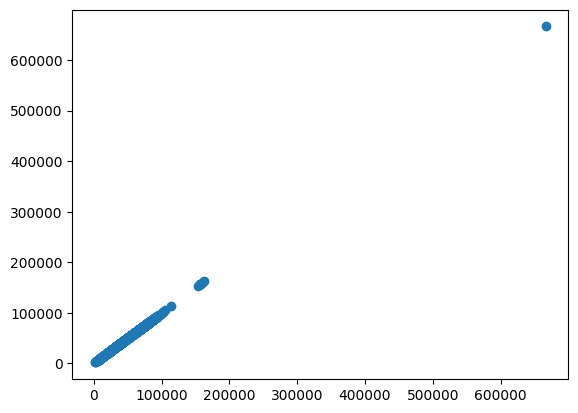

In [189]:
plt.scatter(df['Income'], df['BuyingPower'])

In [190]:
df['TotalPurchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']

In [191]:
def calculate_days_diff(row):
  return (today - row['Dt_CustomerConverted']).days

df['Dt_CustomerConverted'] = pd.to_datetime(df['Dt_Customer'])
today = datetime.today()
df['SinceEnrolled'] = df.apply(calculate_days_diff, axis=1)

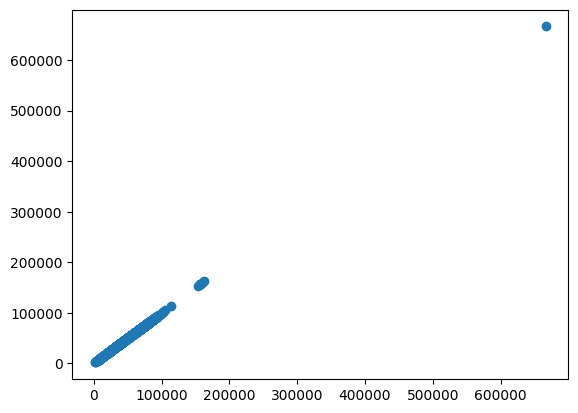

In [192]:
plt.scatter(df['Income'], df['BuyingPower'])    

In [193]:
print(df[df['Marital_Status'] == 'Married'].count())

ID                      864
Year_Birth              864
Education               864
Marital_Status          864
Income                  863
Kidhome                 864
Teenhome                864
Dt_Customer             864
Recency                 864
MntWines                864
MntFruits               864
MntMeatProducts         864
MntFishProducts         864
MntSweetProducts        864
MntGoldProds            864
NumDealsPurchases       864
NumWebPurchases         864
NumCatalogPurchases     864
NumStorePurchases       864
NumWebVisitsMonth       864
Response                864
Complain                864
Age                     864
Total_Spent             864
BuyingPower             857
HouseHoldMembers        864
Total_Children          864
TotalPurchases          864
Dt_CustomerConverted    864
SinceEnrolled           864
dtype: int64


### Customer Lifetime value 

In [194]:
df['CLV'] = (df['Total_Spent'] / 2) * (df['SinceEnrolled'] / 365)

# Average Order Value 

In [195]:
df['AOV'] = df['Total_Spent'] / df['TotalPurchases']

In [ ]:
df = df[df['AOV'] < 1.7976931348623157e+308]

# Saving to Excel 


In [196]:
df.to_excel('Cleaned_Data.xlsx')

In [197]:
df.count()

ID                      2231
Year_Birth              2231
Education               2231
Marital_Status          2231
Income                  2228
Kidhome                 2231
Teenhome                2231
Dt_Customer             2231
Recency                 2231
MntWines                2231
MntFruits               2231
MntMeatProducts         2231
MntFishProducts         2231
MntSweetProducts        2231
MntGoldProds            2231
NumDealsPurchases       2231
NumWebPurchases         2231
NumCatalogPurchases     2231
NumStorePurchases       2231
NumWebVisitsMonth       2231
Response                2231
Complain                2231
Age                     2231
Total_Spent             2231
BuyingPower             2207
HouseHoldMembers        2231
Total_Children          2231
TotalPurchases          2231
Dt_CustomerConverted    2231
SinceEnrolled           2231
CLV                     2231
AOV                     2231
dtype: int64

In [198]:
df = df[df['Income'] < 200000]
df.count()


ID                      2223
Year_Birth              2223
Education               2223
Marital_Status          2223
Income                  2223
Kidhome                 2223
Teenhome                2223
Dt_Customer             2223
Recency                 2223
MntWines                2223
MntFruits               2223
MntMeatProducts         2223
MntFishProducts         2223
MntSweetProducts        2223
MntGoldProds            2223
NumDealsPurchases       2223
NumWebPurchases         2223
NumCatalogPurchases     2223
NumStorePurchases       2223
NumWebVisitsMonth       2223
Response                2223
Complain                2223
Age                     2223
Total_Spent             2223
BuyingPower             2202
HouseHoldMembers        2223
Total_Children          2223
TotalPurchases          2223
Dt_CustomerConverted    2223
SinceEnrolled           2223
CLV                     2223
AOV                     2223
dtype: int64

In [199]:
df.to_excel('Threshold_Data.xlsx')